<a href="https://colab.research.google.com/github/kalyani234/RCT_NLP_CW1/blob/main/NLP_RCT_CW2_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install tensorflow

In [42]:
!pip install umap-learn

In [43]:
!pip install tensorflow transformers wordcloud seaborn

In [44]:
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from wordcloud import WordCloud
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalMaxPool1D, Dropout, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, SimpleRNN, GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [45]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [46]:

from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
dataset_path = '/content/drive/MyDrive/NLP_RCT_Dataset/rct_data.txt'

In [48]:
def remove_duplicate_words(sentence):
    words = sentence.split()
    unique_words = list(dict.fromkeys(words))
    return ' '.join(unique_words)


In [49]:


def preprocess_text(text):
    # Remove specific patterns like sCD40L
    text = re.sub(r'\bsCD40L\b', '', text)

    # Remove text enclosed in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # Remove number ranges like 1-2, 1994-1995
    text = re.sub(r'\b\d{1,4}-\d{1,4}\b', '', text)

    # Remove decimal numbers like 0.324, 6.34
    text = re.sub(r'\b\d+\.\d+\b', '', text)

    # Remove standalone numbers
    text = re.sub(r'\b\d+\b', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation and typographical symbols, replace with space
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra spaces and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize sentences
    sentences = nltk.sent_tokenize(text)

    # Remove duplicate words in each sentence
    sentences = [remove_duplicate_words(sentence) for sentence in sentences]

    # Tokenize into words
    words = word_tokenize(' '.join(sentences))

    # Remove stop words
    words = [word for word in words if word not in stopwords.words('english')]

    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatization and filter out single characters, numbers, and unwanted patterns
    words = [lemmatizer.lemmatize(word) for word in words if len(word) > 1 and not word.isnumeric()]

    # Filter out non-meaningful sequences (e.g., 'iiiv', 'abc123')
    words = [word for word in words if re.match(r'^[a-zA-Z]+$', word)]

    return ' '.join(words)

In [50]:
# Read dataset from txt file
df = pd.read_csv(dataset_path, delimiter='\t', header=None, names=['ID', 'Label', 'Year', 'Title', 'Abstract'])

In [51]:

print("No of Rows: {}".format(df.shape[0]))
print("No of Columns: {}".format(df.shape[1]))

print("\nData View :\n")
print(df.head())

print("\nData Info :\n")
print(df.info())

print("\nData Description :\n")
print(df.describe())

No of Rows: 27063
No of Columns: 5

Data View :

         ID  Label  Year                                              Title  \
0  18439781      0  2011  Two patients subdued with a TASER® device: cas...   
1  18468833      0  2011  A case of Takayasu arteritis causing subclavia...   
2  18481181      0  2012  Pathophysiology of hypopituitarism in the sett...   
3  18728056      1  2011  The cardiovascular risk factor, soluble CD40 l...   
4  18790590      0  2011         Horner syndrome due to carotid dissection.   

                                            Abstract  
0  In the United States, an increasing number of ...  
1  The American Heart Association website defines...  
2  The complex pathophysiology of traumatic brain...  
3  [BACKGROUND] Soluble CD40 ligand (sCD40L) is a...  
4  [BACKGROUND] Internal carotid artery dissectio...  

Data Info :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27063 entries, 0 to 27062
Data columns (total 5 columns):
 #   Column    Non-Null 

In [52]:
#Trim unnecessary spaces for strings
df["Title"] = df["Title"].apply(lambda x: x.strip() if isinstance(x, str) else x)
df["Abstract"] = df["Abstract"].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [53]:
# Combine title and abstract into one column
df['text'] = df['Title'] + ' ' + df['Abstract']

In [54]:
# Print before preprocessing
print("Before Preprocessing:")

#print(df['text'].head())
print(df['text'][5])

Before Preprocessing:
Cocaine-induced agitated delirium with associated hyperthermia: a case report. [BACKGROUND] "Cocaine-induced agitated delirium with associated hyperthermia" is a rare, almost uniformly fatal syndrome. The incidence of the disease is not known, however, it is believed to have markedly increased since the late 1980s with widespread popularity of crack cocaine. [OBJECTIVE] Recent literature is lacking regarding this rare syndrome. Although almost uniformly fatal, we present a neurologically intact survivor due to a multidisciplinary team approach. [CASE REPORT] We are reporting a 41-year-old African-American man who arrived at the trauma center with a rectal temperature of 42.6°C (108.6°F) and a toxicology screen positive for cocaine. The patient manifested many of the known complications of cocaine-induced agitated delirium with associated hyperthermia, including renal failure and coagulation panel abnormalities. With early application of cooling techniques, includi

In [55]:

# Apply preprocessing
tqdm.pandas()  # Initialize tqdm for progress bar
df['processed_text'] = df['text'].progress_apply(preprocess_text)

100%|██████████| 27063/27063 [07:57<00:00, 56.72it/s]


In [56]:

# Print after preprocessing
print("\nAfter Preprocessing:")
print("No of Rows: {}".format(df.shape[0]))
print("No of Columns: {}".format(df.shape[1]))
#print(df['processed_text'].head())
print(df['processed_text'][5])


After Preprocessing:
No of Rows: 27063
No of Columns: 7
cocaine induced agitated delirium associated hyperthermia case report rare almost uniformly fatal syndrome incidence disease known however believed markedly increased since late widespread popularity crack recent literature lacking regarding although present neurologically intact survivor due multidisciplinary team approach reporting year old african american man arrived trauma center rectal temperature toxicology screen positive patient manifested many complication including renal failure coagulation panel abnormality early application cooling technique ice pack gastric lavage bilateral chest cavity using multiple tube core quickly lowered demonstrated emergency medicine critical care specialist aggressive treatment tube thoracostomy enabled effectively unable find prior report manner


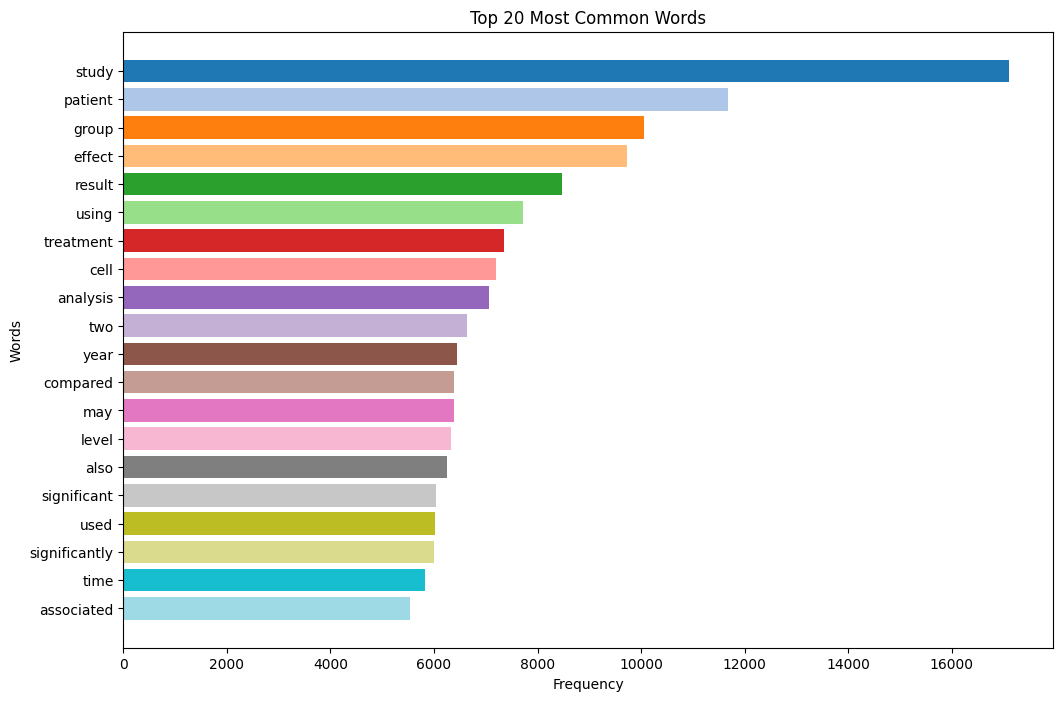

In [57]:
from collections import Counter
# Calculate word frequencies
all_words = ' '.join(df['processed_text']).split()
word_freq = Counter(all_words)

# Get the top 20 most common words
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

# Generate a colormap
colors = plt.cm.tab20(np.linspace(0, 1, len(words)))

# Plot the word frequency bar plot with different colors for each bar
plt.figure(figsize=(12, 8))
bars = plt.barh(words, counts, color=colors)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Most Common Words')
plt.gca().invert_yaxis()
plt.show()

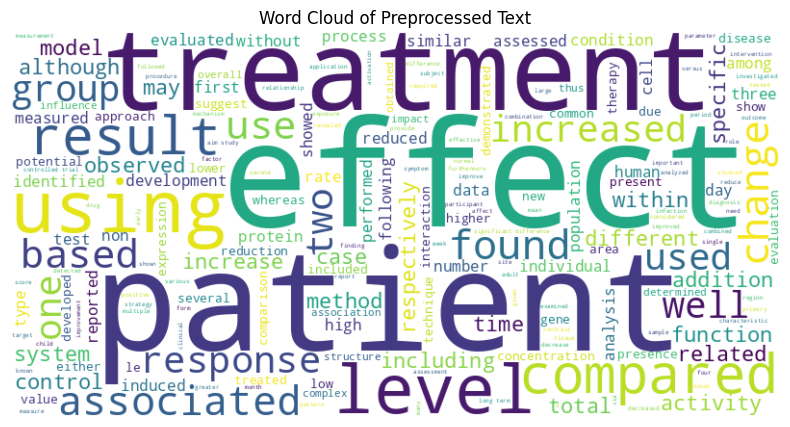

In [58]:
# Word Cloud visualization for preprocessed text
all_text = ' '.join(df['processed_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Preprocessed Text')
plt.show()

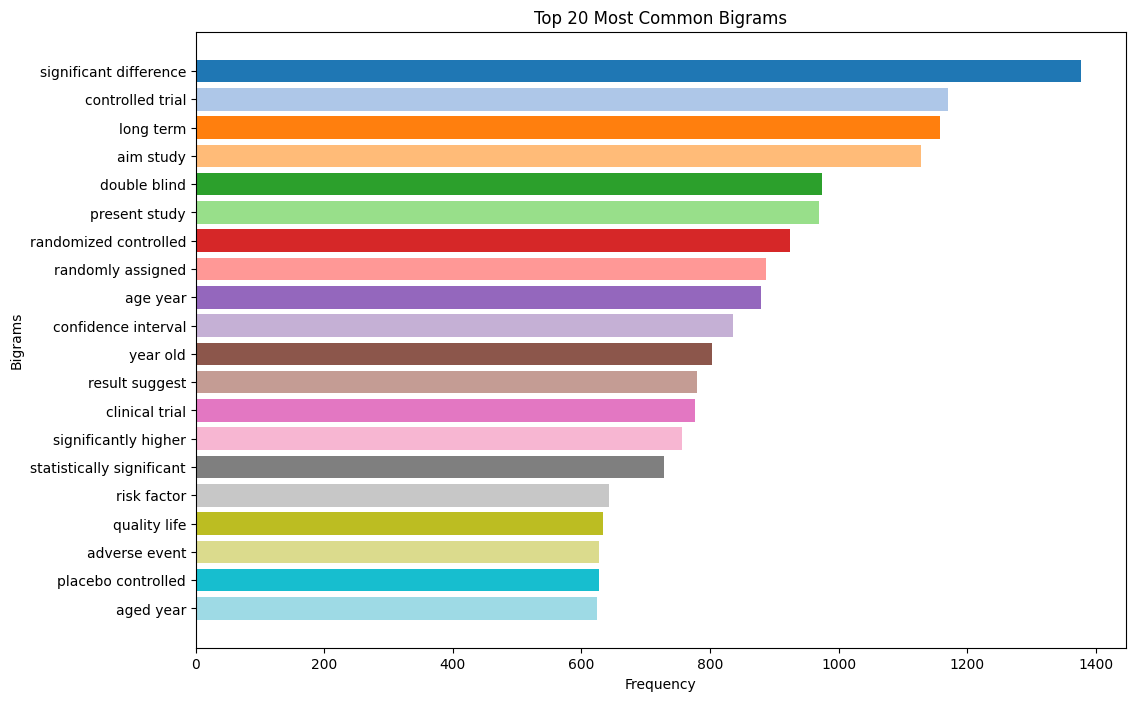

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
# Extract bigrams using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform([all_text])
bigram_freq = Counter(dict(zip(vectorizer.get_feature_names_out(), X.toarray().flatten())))

# Get the top 20 most common bigrams
common_bigrams = bigram_freq.most_common(20)
bigrams, counts = zip(*common_bigrams)

# Generate a colormap
colors = plt.cm.tab20(np.linspace(0, 1, len(bigrams)))

# Plot the bigram frequency bar plot with different colors for each bar
plt.figure(figsize=(12, 8))
bars = plt.barh(bigrams, counts, color=colors)
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top 20 Most Common Bigrams')
plt.gca().invert_yaxis()
plt.show()

In [60]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Tokenize and pad sequences
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['processed_text'])
sequences = tokenizer.texts_to_sequences(df['processed_text'])
word_index = tokenizer.word_index
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Load GloVe embeddings
def load_glove_embeddings(glove_path):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_path = '/content/drive/MyDrive/NLP_RCT_Dataset/Glove_dir/glove.6B.100d.txt'  # Update path to GloVe embeddings
embeddings_index = load_glove_embeddings(glove_path)


In [61]:
# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['processed_text'], df['Label'], test_size=0.2, random_state=42)
X_train = tokenizer.texts_to_sequences(train_texts)
X_test = tokenizer.texts_to_sequences(test_texts)
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)


In [62]:
# Function to plot model performance
def plot_model_performance(history, model_name):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Epoch 1/10
542/542 [==============================] - 65s 112ms/step - loss: 0.2748 - accuracy: 0.8940 - val_loss: 0.1901 - val_accuracy: 0.9323
Epoch 2/10
542/542 [==============================] - 61s 113ms/step - loss: 0.1914 - accuracy: 0.9327 - val_loss: 0.1740 - val_accuracy: 0.9333
Epoch 3/10
542/542 [==============================] - 61s 113ms/step - loss: 0.1653 - accuracy: 0.9393 - val_loss: 0.1596 - val_accuracy: 0.9381
Epoch 4/10
542/542 [==============================] - 61s 113ms/step - loss: 0.1464 - accuracy: 0.9472 - val_loss: 0.1662 - val_accuracy: 0.9363
Epoch 5/10
542/542 [==============================] - 61s 113ms/step - loss: 0.1242 - accuracy: 0.9546 - val_loss: 0.1665 - val_accuracy: 0.9436
Epoch 6/10
170/170 [==============================] - 6s 30ms/step

BiLSTM Metrics:
Accuracy: 0.9436541795730591
Precision: 0.8940397350993378
Recall: 0.8304042179261862
F1 Score: 0.8610478359908884


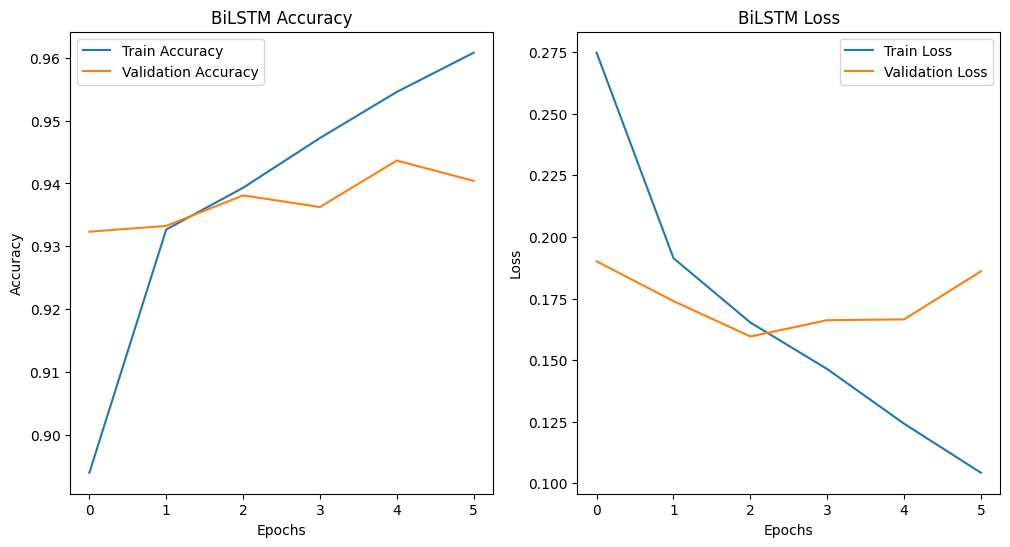

In [63]:
# Define and compile BiLSTM model
bilstm_model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPool1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train BiLSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
bilstm_history = bilstm_model.fit(X_train, train_labels, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate BiLSTM model
bilstm_loss, bilstm_accuracy = bilstm_model.evaluate(X_test, test_labels)
bilstm_y_pred_proba = bilstm_model.predict(X_test).ravel()
bilstm_y_pred = (bilstm_y_pred_proba > 0.5).astype(int)

# BiLSTM metrics
bilstm_precision = precision_score(test_labels, bilstm_y_pred)
bilstm_recall = recall_score(test_labels, bilstm_y_pred)
bilstm_f1 = f1_score(test_labels, bilstm_y_pred)

print("\nBiLSTM Metrics:")
print(f"Accuracy: {bilstm_accuracy}")
print(f"Precision: {bilstm_precision}")
print(f"Recall: {bilstm_recall}")
print(f"F1 Score: {bilstm_f1}")

plot_model_performance(bilstm_history, 'BiLSTM')

Epoch 1/10
542/542 [==============================] - 20s 34ms/step - loss: 0.3083 - accuracy: 0.8720 - val_loss: 0.2007 - val_accuracy: 0.9238
Epoch 2/10
542/542 [==============================] - 17s 32ms/step - loss: 0.1896 - accuracy: 0.9313 - val_loss: 0.2003 - val_accuracy: 0.9277
Epoch 3/10
542/542 [==============================] - 16s 30ms/step - loss: 0.1319 - accuracy: 0.9495 - val_loss: 0.2081 - val_accuracy: 0.9305
Epoch 4/10
542/542 [==============================] - 16s 30ms/step - loss: 0.0711 - accuracy: 0.9749 - val_loss: 0.2468 - val_accuracy: 0.9300
Epoch 5/10
170/170 [==============================] - 2s 10ms/step

CNN Metrics:
Accuracy: 0.930168092250824
Precision: 0.9175824175824175
Recall: 0.7337434094903339
F1 Score: 0.8154296875


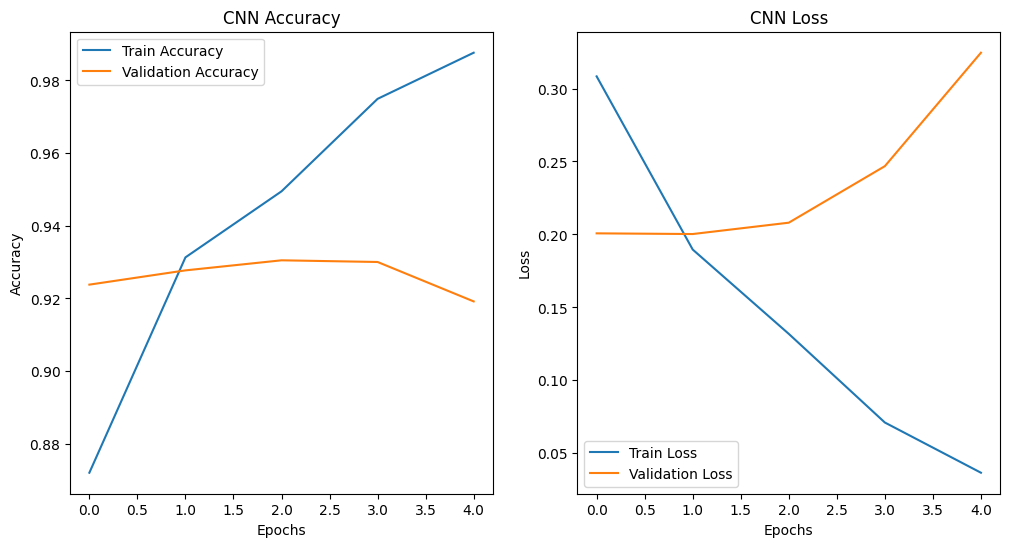

In [64]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Flatten
# Define and compile CNN model
cnn_model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train CNN model
cnn_history = cnn_model.fit(X_train, train_labels, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, test_labels)
cnn_y_pred_proba = cnn_model.predict(X_test).ravel()
cnn_y_pred = (cnn_y_pred_proba > 0.5).astype(int)

# CNN metrics
cnn_precision = precision_score(test_labels, cnn_y_pred)
cnn_recall = recall_score(test_labels, cnn_y_pred)
cnn_f1 = f1_score(test_labels, cnn_y_pred)

print("\nCNN Metrics:")
print(f"Accuracy: {cnn_accuracy}")
print(f"Precision: {cnn_precision}")
print(f"Recall: {cnn_recall}")
print(f"F1 Score: {cnn_f1}")

plot_model_performance(cnn_history, 'CNN')

Epoch 1/10
542/542 [==============================] - 19s 30ms/step - loss: 0.3570 - accuracy: 0.8614 - val_loss: 0.2162 - val_accuracy: 0.9249
Epoch 2/10
542/542 [==============================] - 16s 30ms/step - loss: 0.2290 - accuracy: 0.9236 - val_loss: 0.1979 - val_accuracy: 0.9236
Epoch 3/10
542/542 [==============================] - 16s 29ms/step - loss: 0.2024 - accuracy: 0.9312 - val_loss: 0.1937 - val_accuracy: 0.9266
Epoch 4/10
542/542 [==============================] - 16s 30ms/step - loss: 0.1856 - accuracy: 0.9361 - val_loss: 0.1831 - val_accuracy: 0.9328
Epoch 5/10
542/542 [==============================] - 16s 30ms/step - loss: 0.1723 - accuracy: 0.9407 - val_loss: 0.1812 - val_accuracy: 0.9342
Epoch 6/10
542/542 [==============================] - 16s 30ms/step - loss: 0.1602 - accuracy: 0.9455 - val_loss: 0.1814 - val_accuracy: 0.9356
Epoch 7/10
542/542 [==============================] - 17s 31ms/step - loss: 0.1489 - accuracy: 0.9469 - val_loss: 0.1880 - val_accuracy:

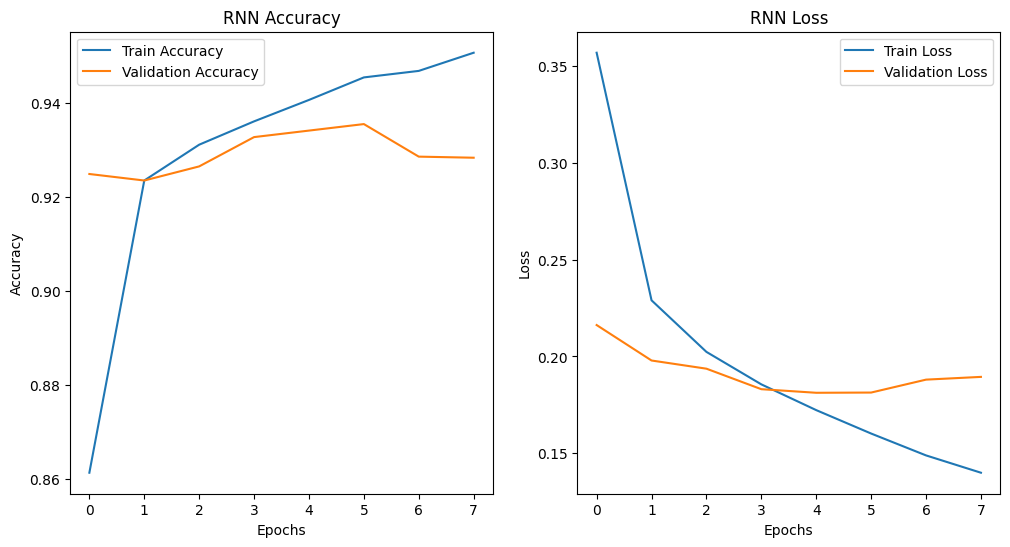

In [65]:
from tensorflow.keras.layers import SimpleRNN
# Define and compile RNN model
rnn_model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    SimpleRNN(64, return_sequences=True),
    GlobalMaxPool1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train RNN model
rnn_history = rnn_model.fit(X_train, train_labels, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate RNN model
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, test_labels)
rnn_y_pred_proba = rnn_model.predict(X_test).ravel()
rnn_y_pred = (rnn_y_pred_proba > 0.5).astype(int)

# RNN metrics
rnn_precision = precision_score(test_labels, rnn_y_pred)
rnn_recall = recall_score(test_labels, rnn_y_pred)
rnn_f1 = f1_score(test_labels, rnn_y_pred)

print("\nRNN Metrics:")
print(f"Accuracy: {rnn_accuracy}")
print(f"Precision: {rnn_precision}")
print(f"Recall: {rnn_recall}")
print(f"F1 Score: {rnn_f1}")

plot_model_performance(rnn_history, 'RNN')


Epoch 1/10
542/542 [==============================] - 36s 62ms/step - loss: 0.3016 - accuracy: 0.8810 - val_loss: 0.2154 - val_accuracy: 0.9233
Epoch 2/10
542/542 [==============================] - 34s 63ms/step - loss: 0.2072 - accuracy: 0.9272 - val_loss: 0.1752 - val_accuracy: 0.9395
Epoch 3/10
542/542 [==============================] - 36s 67ms/step - loss: 0.1801 - accuracy: 0.9355 - val_loss: 0.1701 - val_accuracy: 0.9395
Epoch 4/10
542/542 [==============================] - 33s 61ms/step - loss: 0.1619 - accuracy: 0.9414 - val_loss: 0.1623 - val_accuracy: 0.9411
Epoch 5/10
542/542 [==============================] - 33s 60ms/step - loss: 0.1460 - accuracy: 0.9468 - val_loss: 0.1574 - val_accuracy: 0.9432
Epoch 6/10
542/542 [==============================] - 42s 78ms/step - loss: 0.1306 - accuracy: 0.9519 - val_loss: 0.1632 - val_accuracy: 0.9439
Epoch 7/10
542/542 [==============================] - 36s 67ms/step - loss: 0.1122 - accuracy: 0.9577 - val_loss: 0.1780 - val_accuracy:

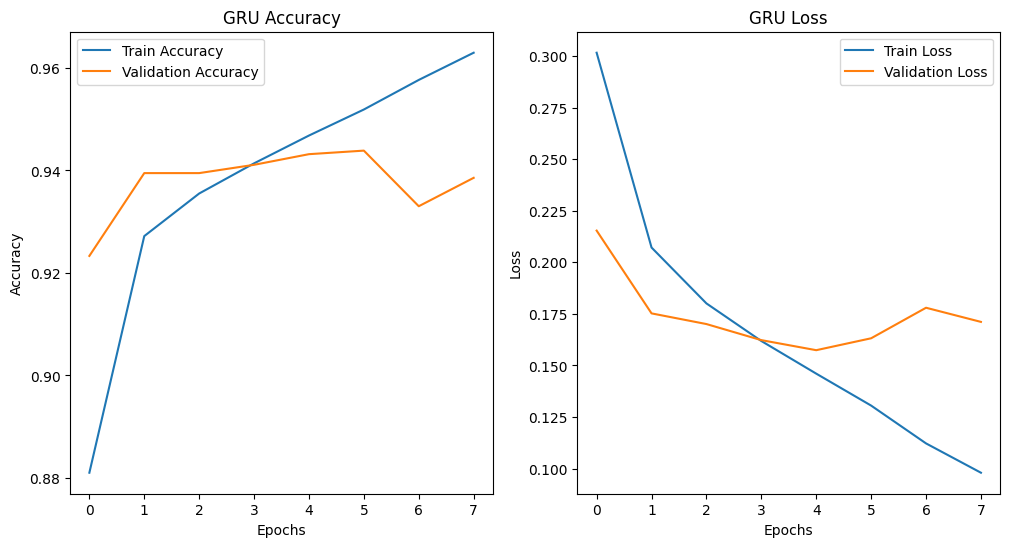

In [66]:
from tensorflow.keras.layers import GRU
# Define and compile GRU model
gru_model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    GRU(64, return_sequences=True),
    GlobalMaxPool1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train GRU model
gru_history = gru_model.fit(X_train, train_labels, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate GRU model
gru_loss, gru_accuracy = gru_model.evaluate(X_test, test_labels)
gru_y_pred_proba = gru_model.predict(X_test).ravel()
gru_y_pred = (gru_y_pred_proba > 0.5).astype(int)

# GRU metrics
gru_precision = precision_score(test_labels, gru_y_pred)
gru_recall = recall_score(test_labels, gru_y_pred)
gru_f1 = f1_score(test_labels, gru_y_pred)

print("\nGRU Metrics:")
print(f"Accuracy: {gru_accuracy}")
print(f"Precision: {gru_precision}")
print(f"Recall: {gru_recall}")
print(f"F1 Score: {gru_f1}")

plot_model_performance(gru_history, 'GRU')

ROC AUC Scores for Each Model:
--------------------------------------------------
BiLSTM: ROC AUC = 0.97
CNN: ROC AUC = 0.96
RNN: ROC AUC = 0.96
GRU: ROC AUC = 0.97


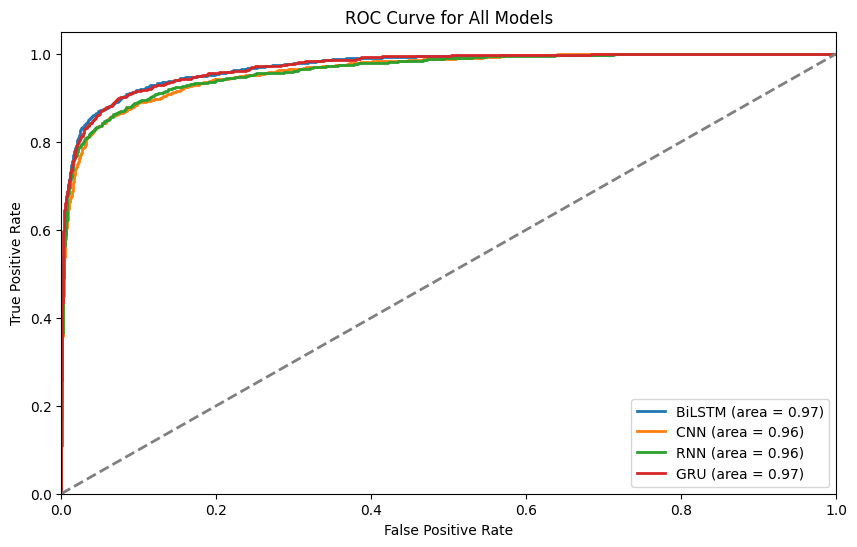

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to compute ROC AUC
def compute_roc_auc(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Function to plot all ROC Curves and print AUC scores
def plot_all_roc_curves_and_print_scores(roc_data):
    plt.figure(figsize=(10, 6))

    print("ROC AUC Scores for Each Model:")
    print("-" * 50)

    # Loop through each model's ROC data
    for model_name, (fpr, tpr, roc_auc) in roc_data.items():
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (area = {roc_auc:.2f})')
        print(f'{model_name}: ROC AUC = {roc_auc:.2f}')  # Print the ROC AUC score

    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for All Models')
    plt.legend(loc="lower right")
    plt.show()

# Dictionary of models and their predictions
models = {
    'BiLSTM': bilstm_y_pred_proba,
    'CNN': cnn_y_pred_proba,
    'RNN': rnn_y_pred_proba,
    'GRU': gru_y_pred_proba
}

# Dictionary to store ROC data for each model
roc_data = {}

# Compute ROC AUC for each model and store it in roc_data
for model_name, y_pred_proba in models.items():
    fpr, tpr, roc_auc = compute_roc_auc(test_labels, y_pred_proba)
    roc_data[model_name] = (fpr, tpr, roc_auc)

# Plot all ROC curves and print ROC AUC scores
plot_all_roc_curves_and_print_scores(roc_data)


Precision-Recall Average Precision Scores for Each Model:
--------------------------------------------------
BiLSTM: Average Precision = 0.93
CNN: Average Precision = 0.90
RNN: Average Precision = 0.91
GRU: Average Precision = 0.93


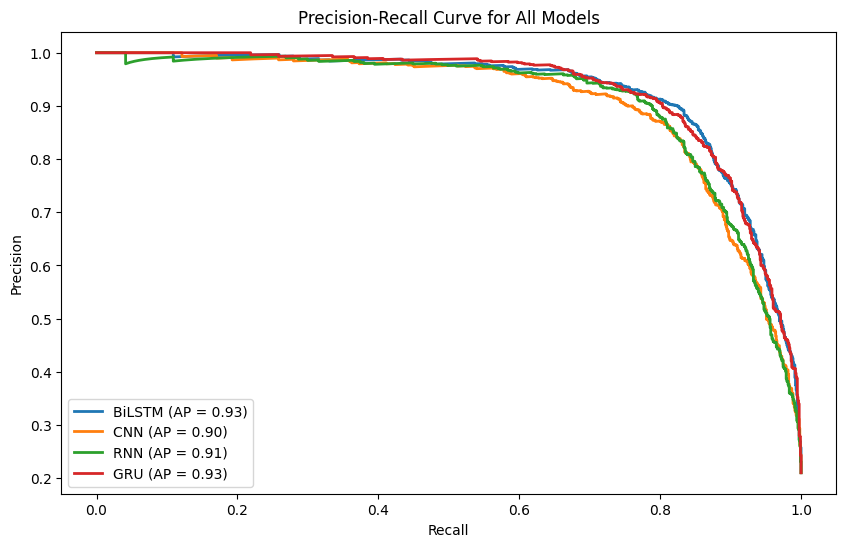

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Function to compute Precision-Recall and Average Precision
def compute_precision_recall(y_true, y_pred_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    average_precision = average_precision_score(y_true, y_pred_proba)
    return precision, recall, average_precision

# Function to plot all Precision-Recall Curves and print Average Precision scores
def plot_all_precision_recall_curves_and_print_scores(pr_data):
    plt.figure(figsize=(10, 6))

    print("Precision-Recall Average Precision Scores for Each Model:")
    print("-" * 50)

    # Loop through each model's PR data
    for model_name, (precision, recall, average_precision) in pr_data.items():
        plt.plot(recall, precision, lw=2, label=f'{model_name} (AP = {average_precision:.2f})')
        print(f'{model_name}: Average Precision = {average_precision:.2f}')  # Print the Average Precision score

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for All Models')
    plt.legend(loc="lower left")
    plt.show()

# Dictionary of models and their predictions
models = {
    'BiLSTM': bilstm_y_pred_proba,
    'CNN': cnn_y_pred_proba,
    'RNN': rnn_y_pred_proba,
    'GRU': gru_y_pred_proba
}

# Dictionary to store Precision-Recall data for each model
pr_data = {}

# Compute Precision-Recall for each model and store it in pr_data
for model_name, y_pred_proba in models.items():
    precision, recall, average_precision = compute_precision_recall(test_labels, y_pred_proba)
    pr_data[model_name] = (precision, recall, average_precision)

# Plot all Precision-Recall curves and print Average Precision scores
plot_all_precision_recall_curves_and_print_scores(pr_data)

The best model is: BiLSTM

Performance metrics for the best model:
Accuracy         0.943654
Precision        0.894040
Recall           0.830404
F1 Score         0.861048
Average Score    0.882286
Name: BiLSTM, dtype: float64


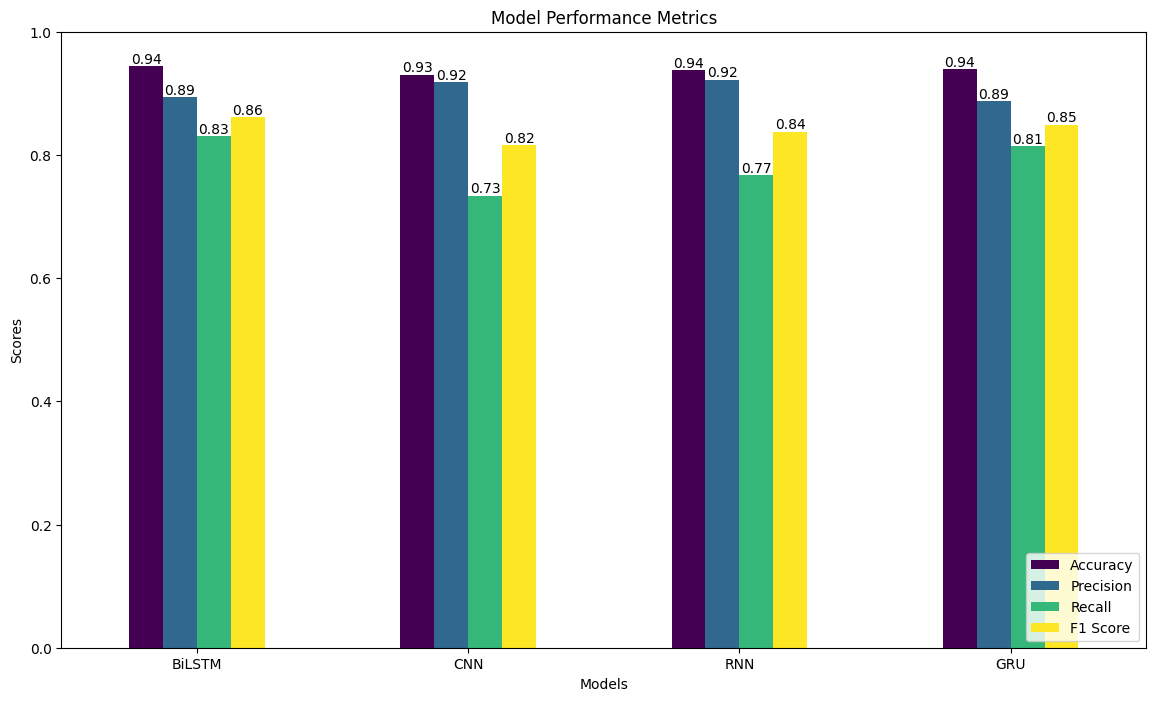

In [78]:
# Define the metrics for each model
metrics = {
    'BiLSTM': {
        'Accuracy': bilstm_accuracy,
        'Precision': bilstm_precision,
        'Recall': bilstm_recall,
        'F1 Score': bilstm_f1
    },
    'CNN': {
        'Accuracy': cnn_accuracy,
        'Precision': cnn_precision,
        'Recall': cnn_recall,
        'F1 Score': cnn_f1
    },
    'RNN': {
        'Accuracy': rnn_accuracy,
        'Precision': rnn_precision,
        'Recall': rnn_recall,
        'F1 Score': rnn_f1
    },
    'GRU': {
        'Accuracy': gru_accuracy,
        'Precision': gru_precision,
        'Recall': gru_recall,
        'F1 Score': gru_f1
    }
}


# Convert the metrics dictionary to a DataFrame for easier comparison
metrics_df = pd.DataFrame(metrics)

# Transpose the DataFrame for better access
metrics_df = metrics_df.T

# Calculate the average score for each model (you can adjust this to prioritize specific metrics)
metrics_df['Average Score'] = metrics_df.mean(axis=1)

# Find the best model based on the highest average score
best_model = metrics_df['Average Score'].idxmax()
best_model_metrics = metrics_df.loc[best_model]

print(f"The best model is: {best_model}")
print("\nPerformance metrics for the best model:")
print(best_model_metrics)

# Visualize the performance metrics of all models
ax = metrics_df.drop(columns=['Average Score']).plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title('Model Performance Metrics')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=0)

# Add score labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.show()